# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0K/60.0K [01:10<00:00, 857File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

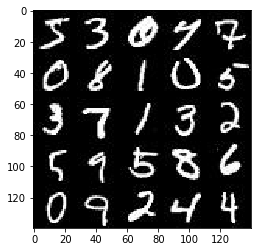

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

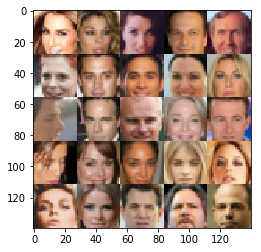

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


C:\Users\H00164\AppData\Local\Continuum\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'input_real')
    input_z = tf.placeholder(tf.float32, (None,z_dim), 'input_z')
    learning_rate = tf.placeholder(tf.float32, None, 'learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\H00164\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\H00164\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\H00164\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py3\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\H00164\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\H00164\\AppData\\Local\\Continuum\\Anaconda3\\e

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [113]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.7
    with tf.variable_scope('discriminator', reuse=reuse):
        #input as 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        x1 = tf.maximum(x1, x1 * alpha)
        #out 14x14x32
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2 * alpha)
        #out 7x7x64
        
        x3 = tf.layers.conv2d(x2, 256, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        #out 4x4x128
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        dropout = tf.layers.dropout(flatten, rate=keep_prob)
        logits = tf.layers.dense(dropout, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [114]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.7
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        x0 = tf.layers.dense(z, 7*7*512)
    
        x1 = tf.reshape(x0, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x64
        
        x3 = tf.layers.dropout(x3, keep_prob)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [115]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [116]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [117]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [125]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images = data_shape[0]
    input_real, input_z, lrate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    cnt=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                cnt+=1
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrate: learning_rate})
                if cnt % 20 == 0:
                    #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch:{}/{} Images:{}/{}".format(epoch_i, epoch_count, cnt*batch_size, n_images),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g))  
                if cnt % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
L
Epoch:0/2 Images:640/60000 Discriminator Loss: 0.5312... Generator Loss: 5.5344
Epoch:0/2 Images:1280/60000 Discriminator Loss: 0.6735... Generator Loss: 5.4547
Epoch:0/2 Images:1920/60000 Discriminator Loss: 0.4243... Generator Loss: 3.9277
Epoch:0/2 Images:2560/60000 Discriminator Loss: 1.2239... Generator Loss: 0.8776
Epoch:0/2 Images:3200/60000 Discriminator Loss: 1.2252... Generator Loss: 1.1313
Epoch:0/2 Images:3840/60000 Discriminator Loss: 1.1914... Generator Loss: 1.4954
Epoch:0/2 Images:4480/60000 Discriminator Loss: 1.3229... Generator Loss: 0.6992
Epoch:0/2 Images:5120/60000 Discriminator Loss: 1.0353... Generator Loss: 1.3213
Epoch:0/2 Images:5760/60000 Discriminator Loss: 1.1712... Generator Loss: 0.8011
Epoch:0/2 Images:6400/60000 Discriminator Loss: 1.4036... Generator Loss: 0.6192


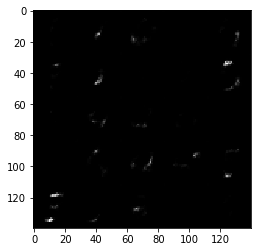

Epoch:0/2 Images:7040/60000 Discriminator Loss: 0.9913... Generator Loss: 1.0174
Epoch:0/2 Images:7680/60000 Discriminator Loss: 1.3280... Generator Loss: 0.7835
Epoch:0/2 Images:8320/60000 Discriminator Loss: 1.1957... Generator Loss: 1.0986
Epoch:0/2 Images:8960/60000 Discriminator Loss: 1.2336... Generator Loss: 0.8655
Epoch:0/2 Images:9600/60000 Discriminator Loss: 1.6373... Generator Loss: 0.4578
Epoch:0/2 Images:10240/60000 Discriminator Loss: 1.2685... Generator Loss: 0.7494
Epoch:0/2 Images:10880/60000 Discriminator Loss: 1.3096... Generator Loss: 0.5867
Epoch:0/2 Images:11520/60000 Discriminator Loss: 1.3083... Generator Loss: 0.7111
Epoch:0/2 Images:12160/60000 Discriminator Loss: 1.3601... Generator Loss: 0.6536
Epoch:0/2 Images:12800/60000 Discriminator Loss: 1.2894... Generator Loss: 0.6725


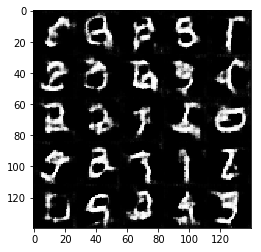

Epoch:0/2 Images:13440/60000 Discriminator Loss: 1.1111... Generator Loss: 1.2073
Epoch:0/2 Images:14080/60000 Discriminator Loss: 1.3207... Generator Loss: 0.7580
Epoch:0/2 Images:14720/60000 Discriminator Loss: 1.2028... Generator Loss: 0.9668
Epoch:0/2 Images:15360/60000 Discriminator Loss: 1.2561... Generator Loss: 0.9590
Epoch:0/2 Images:16000/60000 Discriminator Loss: 1.3480... Generator Loss: 0.5779
Epoch:0/2 Images:16640/60000 Discriminator Loss: 1.1482... Generator Loss: 0.8689
Epoch:0/2 Images:17280/60000 Discriminator Loss: 1.2005... Generator Loss: 0.6891
Epoch:0/2 Images:17920/60000 Discriminator Loss: 1.1594... Generator Loss: 1.4174
Epoch:0/2 Images:18560/60000 Discriminator Loss: 1.2165... Generator Loss: 0.9001
Epoch:0/2 Images:19200/60000 Discriminator Loss: 1.2334... Generator Loss: 0.8701


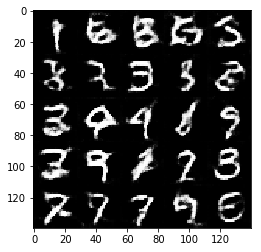

Epoch:0/2 Images:19840/60000 Discriminator Loss: 1.1543... Generator Loss: 0.8698
Epoch:0/2 Images:20480/60000 Discriminator Loss: 1.0090... Generator Loss: 1.1602
Epoch:0/2 Images:21120/60000 Discriminator Loss: 1.0261... Generator Loss: 1.2099
Epoch:0/2 Images:21760/60000 Discriminator Loss: 0.9989... Generator Loss: 1.2213
Epoch:0/2 Images:22400/60000 Discriminator Loss: 1.1479... Generator Loss: 0.7333
Epoch:0/2 Images:23040/60000 Discriminator Loss: 1.2166... Generator Loss: 0.8805
Epoch:0/2 Images:23680/60000 Discriminator Loss: 1.2736... Generator Loss: 0.7795
Epoch:0/2 Images:24320/60000 Discriminator Loss: 0.8814... Generator Loss: 1.2302
Epoch:0/2 Images:24960/60000 Discriminator Loss: 1.8191... Generator Loss: 0.3319
Epoch:0/2 Images:25600/60000 Discriminator Loss: 1.5690... Generator Loss: 0.4271


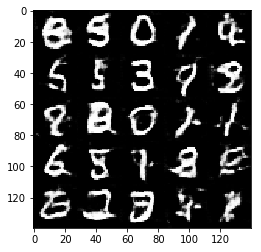

Epoch:0/2 Images:26240/60000 Discriminator Loss: 1.1154... Generator Loss: 1.0975
Epoch:0/2 Images:26880/60000 Discriminator Loss: 1.0636... Generator Loss: 1.7695
Epoch:0/2 Images:27520/60000 Discriminator Loss: 1.3987... Generator Loss: 0.6274
Epoch:0/2 Images:28160/60000 Discriminator Loss: 1.7405... Generator Loss: 0.3358
Epoch:0/2 Images:28800/60000 Discriminator Loss: 1.0174... Generator Loss: 0.9484
Epoch:0/2 Images:29440/60000 Discriminator Loss: 1.2402... Generator Loss: 0.7830
Epoch:0/2 Images:30080/60000 Discriminator Loss: 1.3582... Generator Loss: 0.5810
Epoch:0/2 Images:30720/60000 Discriminator Loss: 1.0226... Generator Loss: 1.0291
Epoch:0/2 Images:31360/60000 Discriminator Loss: 1.1238... Generator Loss: 0.8278
Epoch:0/2 Images:32000/60000 Discriminator Loss: 1.6365... Generator Loss: 0.3799


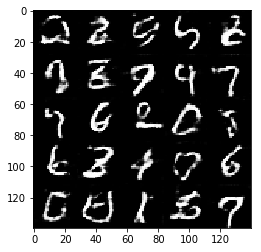

Epoch:0/2 Images:32640/60000 Discriminator Loss: 1.1753... Generator Loss: 0.7061
Epoch:0/2 Images:33280/60000 Discriminator Loss: 0.9118... Generator Loss: 1.3000
Epoch:0/2 Images:33920/60000 Discriminator Loss: 1.2539... Generator Loss: 0.6734
Epoch:0/2 Images:34560/60000 Discriminator Loss: 0.9799... Generator Loss: 1.2996
Epoch:0/2 Images:35200/60000 Discriminator Loss: 1.5859... Generator Loss: 0.4730
Epoch:0/2 Images:35840/60000 Discriminator Loss: 1.1284... Generator Loss: 0.9217
Epoch:0/2 Images:36480/60000 Discriminator Loss: 1.0927... Generator Loss: 1.1954
Epoch:0/2 Images:37120/60000 Discriminator Loss: 0.9610... Generator Loss: 1.0862
Epoch:0/2 Images:37760/60000 Discriminator Loss: 1.7797... Generator Loss: 0.3449
Epoch:0/2 Images:38400/60000 Discriminator Loss: 0.9766... Generator Loss: 0.9651


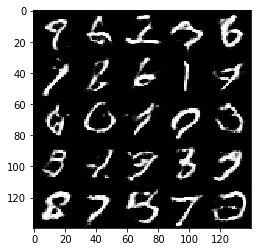

Epoch:0/2 Images:39040/60000 Discriminator Loss: 1.1930... Generator Loss: 0.8986
Epoch:0/2 Images:39680/60000 Discriminator Loss: 0.8434... Generator Loss: 1.2177
Epoch:0/2 Images:40320/60000 Discriminator Loss: 0.9094... Generator Loss: 1.4012
Epoch:0/2 Images:40960/60000 Discriminator Loss: 0.8900... Generator Loss: 1.2609
Epoch:0/2 Images:41600/60000 Discriminator Loss: 1.3093... Generator Loss: 0.6978
Epoch:0/2 Images:42240/60000 Discriminator Loss: 1.1409... Generator Loss: 0.7163
Epoch:0/2 Images:42880/60000 Discriminator Loss: 1.1681... Generator Loss: 0.7586
Epoch:0/2 Images:43520/60000 Discriminator Loss: 1.2483... Generator Loss: 0.8106
Epoch:0/2 Images:44160/60000 Discriminator Loss: 1.1226... Generator Loss: 0.7636
Epoch:0/2 Images:44800/60000 Discriminator Loss: 1.1709... Generator Loss: 0.7242


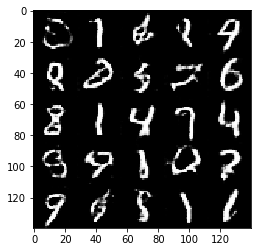

Epoch:0/2 Images:45440/60000 Discriminator Loss: 1.3606... Generator Loss: 0.6213
Epoch:0/2 Images:46080/60000 Discriminator Loss: 1.1696... Generator Loss: 0.7419
Epoch:0/2 Images:46720/60000 Discriminator Loss: 0.9697... Generator Loss: 1.0052
Epoch:0/2 Images:47360/60000 Discriminator Loss: 0.9877... Generator Loss: 0.8589
Epoch:0/2 Images:48000/60000 Discriminator Loss: 0.8669... Generator Loss: 1.2606
Epoch:0/2 Images:48640/60000 Discriminator Loss: 0.7776... Generator Loss: 1.2968
Epoch:0/2 Images:49280/60000 Discriminator Loss: 1.1513... Generator Loss: 2.1605
Epoch:0/2 Images:49920/60000 Discriminator Loss: 0.9436... Generator Loss: 1.2880
Epoch:0/2 Images:50560/60000 Discriminator Loss: 1.0707... Generator Loss: 1.1478
Epoch:0/2 Images:51200/60000 Discriminator Loss: 0.9610... Generator Loss: 1.3124


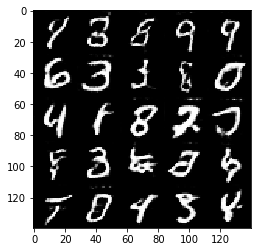

Epoch:0/2 Images:51840/60000 Discriminator Loss: 0.8961... Generator Loss: 1.1068
Epoch:0/2 Images:52480/60000 Discriminator Loss: 0.9232... Generator Loss: 1.1004
Epoch:0/2 Images:53120/60000 Discriminator Loss: 0.8975... Generator Loss: 1.0580
Epoch:0/2 Images:53760/60000 Discriminator Loss: 0.5804... Generator Loss: 2.4498
Epoch:0/2 Images:54400/60000 Discriminator Loss: 0.9420... Generator Loss: 0.9813
Epoch:0/2 Images:55040/60000 Discriminator Loss: 1.2355... Generator Loss: 1.2892
Epoch:0/2 Images:55680/60000 Discriminator Loss: 1.2936... Generator Loss: 0.6276
Epoch:0/2 Images:56320/60000 Discriminator Loss: 1.0519... Generator Loss: 0.7897
Epoch:0/2 Images:56960/60000 Discriminator Loss: 0.6745... Generator Loss: 1.6783
Epoch:0/2 Images:57600/60000 Discriminator Loss: 0.7913... Generator Loss: 1.7779


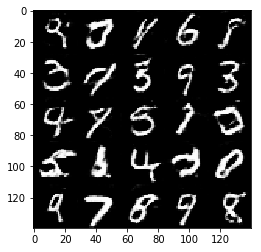

Epoch:0/2 Images:58240/60000 Discriminator Loss: 0.8434... Generator Loss: 1.1940
Epoch:0/2 Images:58880/60000 Discriminator Loss: 0.9067... Generator Loss: 1.1492
Epoch:0/2 Images:59520/60000 Discriminator Loss: 1.2976... Generator Loss: 0.5872
Epoch:1/2 Images:60160/60000 Discriminator Loss: 0.9246... Generator Loss: 1.3870
Epoch:1/2 Images:60800/60000 Discriminator Loss: 0.7623... Generator Loss: 1.4425
Epoch:1/2 Images:61440/60000 Discriminator Loss: 0.9258... Generator Loss: 0.9675
Epoch:1/2 Images:62080/60000 Discriminator Loss: 0.7768... Generator Loss: 1.2937
Epoch:1/2 Images:62720/60000 Discriminator Loss: 1.3065... Generator Loss: 0.6755
Epoch:1/2 Images:63360/60000 Discriminator Loss: 0.9269... Generator Loss: 1.1930
Epoch:1/2 Images:64000/60000 Discriminator Loss: 0.8408... Generator Loss: 1.5138


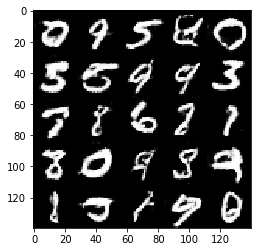

Epoch:1/2 Images:64640/60000 Discriminator Loss: 0.7536... Generator Loss: 1.4519
Epoch:1/2 Images:65280/60000 Discriminator Loss: 0.7503... Generator Loss: 1.8598
Epoch:1/2 Images:65920/60000 Discriminator Loss: 0.6118... Generator Loss: 1.8269
Epoch:1/2 Images:66560/60000 Discriminator Loss: 0.9029... Generator Loss: 1.3117
Epoch:1/2 Images:67200/60000 Discriminator Loss: 0.7258... Generator Loss: 1.8609
Epoch:1/2 Images:67840/60000 Discriminator Loss: 0.7266... Generator Loss: 1.4730
Epoch:1/2 Images:68480/60000 Discriminator Loss: 1.0964... Generator Loss: 1.7499
Epoch:1/2 Images:69120/60000 Discriminator Loss: 0.9979... Generator Loss: 0.9507
Epoch:1/2 Images:69760/60000 Discriminator Loss: 0.7727... Generator Loss: 1.6797
Epoch:1/2 Images:70400/60000 Discriminator Loss: 0.8601... Generator Loss: 1.1218


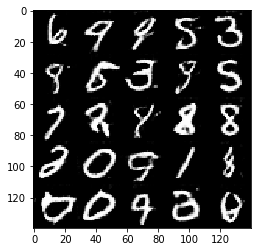

Epoch:1/2 Images:71040/60000 Discriminator Loss: 0.7905... Generator Loss: 1.4923
Epoch:1/2 Images:71680/60000 Discriminator Loss: 0.7237... Generator Loss: 1.3683
Epoch:1/2 Images:72320/60000 Discriminator Loss: 0.8466... Generator Loss: 1.2345
Epoch:1/2 Images:72960/60000 Discriminator Loss: 0.6267... Generator Loss: 1.8822
Epoch:1/2 Images:73600/60000 Discriminator Loss: 0.6515... Generator Loss: 1.6200
Epoch:1/2 Images:74240/60000 Discriminator Loss: 0.8795... Generator Loss: 1.0370
Epoch:1/2 Images:74880/60000 Discriminator Loss: 0.9951... Generator Loss: 1.1185
Epoch:1/2 Images:75520/60000 Discriminator Loss: 0.7272... Generator Loss: 2.1388
Epoch:1/2 Images:76160/60000 Discriminator Loss: 0.7662... Generator Loss: 1.2776
Epoch:1/2 Images:76800/60000 Discriminator Loss: 0.7779... Generator Loss: 1.8639


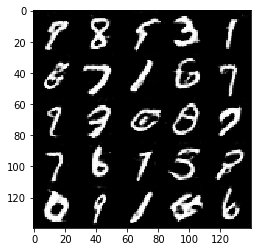

Epoch:1/2 Images:77440/60000 Discriminator Loss: 0.8417... Generator Loss: 1.3333
Epoch:1/2 Images:78080/60000 Discriminator Loss: 0.8848... Generator Loss: 1.9273
Epoch:1/2 Images:78720/60000 Discriminator Loss: 0.8210... Generator Loss: 1.2664
Epoch:1/2 Images:79360/60000 Discriminator Loss: 0.8524... Generator Loss: 1.5074
Epoch:1/2 Images:80000/60000 Discriminator Loss: 1.0394... Generator Loss: 0.7710
Epoch:1/2 Images:80640/60000 Discriminator Loss: 0.9957... Generator Loss: 2.6429
Epoch:1/2 Images:81280/60000 Discriminator Loss: 1.1229... Generator Loss: 0.8327
Epoch:1/2 Images:81920/60000 Discriminator Loss: 0.9998... Generator Loss: 0.9543
Epoch:1/2 Images:82560/60000 Discriminator Loss: 0.8221... Generator Loss: 1.3363
Epoch:1/2 Images:83200/60000 Discriminator Loss: 0.8702... Generator Loss: 2.1259


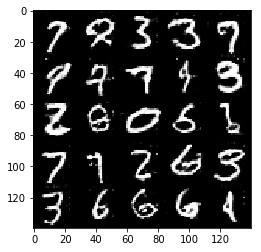

Epoch:1/2 Images:83840/60000 Discriminator Loss: 0.7282... Generator Loss: 1.3714
Epoch:1/2 Images:84480/60000 Discriminator Loss: 1.5475... Generator Loss: 0.4844
Epoch:1/2 Images:85120/60000 Discriminator Loss: 0.7080... Generator Loss: 2.3063
Epoch:1/2 Images:85760/60000 Discriminator Loss: 0.9116... Generator Loss: 1.1374
Epoch:1/2 Images:86400/60000 Discriminator Loss: 1.4775... Generator Loss: 0.4982
Epoch:1/2 Images:87040/60000 Discriminator Loss: 1.0287... Generator Loss: 0.8549
Epoch:1/2 Images:87680/60000 Discriminator Loss: 0.6824... Generator Loss: 1.6292
Epoch:1/2 Images:88320/60000 Discriminator Loss: 1.3372... Generator Loss: 0.7784
Epoch:1/2 Images:88960/60000 Discriminator Loss: 0.6626... Generator Loss: 1.6930
Epoch:1/2 Images:89600/60000 Discriminator Loss: 1.0008... Generator Loss: 0.8281


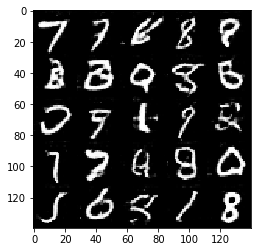

Epoch:1/2 Images:90240/60000 Discriminator Loss: 0.6947... Generator Loss: 1.5514
Epoch:1/2 Images:90880/60000 Discriminator Loss: 0.9184... Generator Loss: 1.0464
Epoch:1/2 Images:91520/60000 Discriminator Loss: 0.7765... Generator Loss: 1.3553
Epoch:1/2 Images:92160/60000 Discriminator Loss: 0.8324... Generator Loss: 2.6154
Epoch:1/2 Images:92800/60000 Discriminator Loss: 0.6937... Generator Loss: 3.1834
Epoch:1/2 Images:93440/60000 Discriminator Loss: 0.7330... Generator Loss: 1.4990
Epoch:1/2 Images:94080/60000 Discriminator Loss: 0.9702... Generator Loss: 0.9510
Epoch:1/2 Images:94720/60000 Discriminator Loss: 0.9808... Generator Loss: 0.9766
Epoch:1/2 Images:95360/60000 Discriminator Loss: 0.8039... Generator Loss: 1.2267
Epoch:1/2 Images:96000/60000 Discriminator Loss: 0.8199... Generator Loss: 1.1958


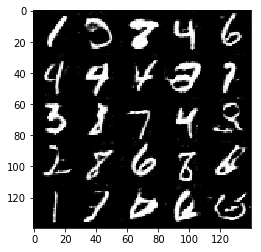

Epoch:1/2 Images:96640/60000 Discriminator Loss: 0.7329... Generator Loss: 1.3789
Epoch:1/2 Images:97280/60000 Discriminator Loss: 1.0207... Generator Loss: 0.9365
Epoch:1/2 Images:97920/60000 Discriminator Loss: 0.5147... Generator Loss: 2.3173
Epoch:1/2 Images:98560/60000 Discriminator Loss: 0.7251... Generator Loss: 1.4641
Epoch:1/2 Images:99200/60000 Discriminator Loss: 1.0175... Generator Loss: 1.1195
Epoch:1/2 Images:99840/60000 Discriminator Loss: 0.7540... Generator Loss: 1.5130
Epoch:1/2 Images:100480/60000 Discriminator Loss: 1.0165... Generator Loss: 0.8544
Epoch:1/2 Images:101120/60000 Discriminator Loss: 0.5739... Generator Loss: 1.7725
Epoch:1/2 Images:101760/60000 Discriminator Loss: 0.9172... Generator Loss: 1.5024
Epoch:1/2 Images:102400/60000 Discriminator Loss: 0.6656... Generator Loss: 1.7674


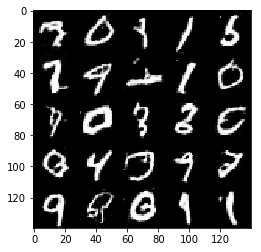

Epoch:1/2 Images:103040/60000 Discriminator Loss: 0.9449... Generator Loss: 1.0759
Epoch:1/2 Images:103680/60000 Discriminator Loss: 0.7759... Generator Loss: 1.5138
Epoch:1/2 Images:104320/60000 Discriminator Loss: 0.8351... Generator Loss: 1.1355
Epoch:1/2 Images:104960/60000 Discriminator Loss: 1.6374... Generator Loss: 0.4582
Epoch:1/2 Images:105600/60000 Discriminator Loss: 0.9749... Generator Loss: 0.9029
Epoch:1/2 Images:106240/60000 Discriminator Loss: 0.8934... Generator Loss: 1.0492
Epoch:1/2 Images:106880/60000 Discriminator Loss: 0.6741... Generator Loss: 2.3444
Epoch:1/2 Images:107520/60000 Discriminator Loss: 0.5651... Generator Loss: 2.2853
Epoch:1/2 Images:108160/60000 Discriminator Loss: 1.2583... Generator Loss: 0.7289
Epoch:1/2 Images:108800/60000 Discriminator Loss: 0.9229... Generator Loss: 1.1164


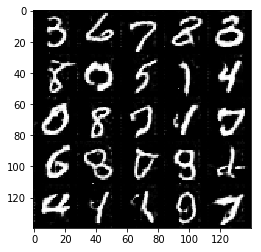

Epoch:1/2 Images:109440/60000 Discriminator Loss: 0.7763... Generator Loss: 1.2272
Epoch:1/2 Images:110080/60000 Discriminator Loss: 1.0488... Generator Loss: 0.9786
Epoch:1/2 Images:110720/60000 Discriminator Loss: 0.9970... Generator Loss: 0.9518
Epoch:1/2 Images:111360/60000 Discriminator Loss: 0.8745... Generator Loss: 1.1047
Epoch:1/2 Images:112000/60000 Discriminator Loss: 0.6655... Generator Loss: 1.9280
Epoch:1/2 Images:112640/60000 Discriminator Loss: 0.8717... Generator Loss: 2.5273
Epoch:1/2 Images:113280/60000 Discriminator Loss: 0.6286... Generator Loss: 2.1562
Epoch:1/2 Images:113920/60000 Discriminator Loss: 0.6562... Generator Loss: 1.7568
Epoch:1/2 Images:114560/60000 Discriminator Loss: 0.5798... Generator Loss: 1.8737
Epoch:1/2 Images:115200/60000 Discriminator Loss: 1.0427... Generator Loss: 0.9688


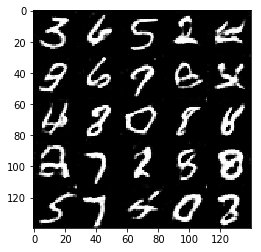

Epoch:1/2 Images:115840/60000 Discriminator Loss: 1.0626... Generator Loss: 0.8680
Epoch:1/2 Images:116480/60000 Discriminator Loss: 1.1307... Generator Loss: 0.7470
Epoch:1/2 Images:117120/60000 Discriminator Loss: 1.0080... Generator Loss: 0.8926
Epoch:1/2 Images:117760/60000 Discriminator Loss: 0.7726... Generator Loss: 1.3204
Epoch:1/2 Images:118400/60000 Discriminator Loss: 1.1671... Generator Loss: 0.7740
Epoch:1/2 Images:119040/60000 Discriminator Loss: 0.7485... Generator Loss: 1.3974
Epoch:1/2 Images:119680/60000 Discriminator Loss: 1.0731... Generator Loss: 0.7969


In [126]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
print(mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:0/1 Images:640/202599 Discriminator Loss: 0.4513... Generator Loss: 2.8672
Epoch:0/1 Images:1280/202599 Discriminator Loss: 0.6788... Generator Loss: 1.8228
Epoch:0/1 Images:1920/202599 Discriminator Loss: 0.9159... Generator Loss: 1.2736
Epoch:0/1 Images:2560/202599 Discriminator Loss: 0.7558... Generator Loss: 1.3882
Epoch:0/1 Images:3200/202599 Discriminator Loss: 2.0075... Generator Loss: 6.4840
Epoch:0/1 Images:3840/202599 Discriminator Loss: 0.3861... Generator Loss: 5.9443
Epoch:0/1 Images:4480/202599 Discriminator Loss: 1.7292... Generator Loss: 0.4253
Epoch:0/1 Images:5120/202599 Discriminator Loss: 0.8868... Generator Loss: 3.4442
Epoch:0/1 Images:5760/202599 Discriminator Loss: 2.3226... Generator Loss: 0.2485
Epoch:0/1 Images:6400/202599 Discriminator Loss: 0.6422... Generator Loss: 3.0583


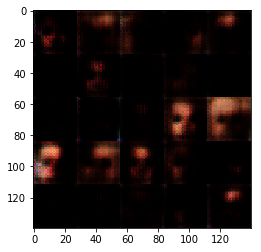

Epoch:0/1 Images:7040/202599 Discriminator Loss: 1.0493... Generator Loss: 0.8971
Epoch:0/1 Images:7680/202599 Discriminator Loss: 0.9989... Generator Loss: 1.0330
Epoch:0/1 Images:8320/202599 Discriminator Loss: 0.8003... Generator Loss: 1.5959
Epoch:0/1 Images:8960/202599 Discriminator Loss: 1.1774... Generator Loss: 0.8191
Epoch:0/1 Images:9600/202599 Discriminator Loss: 1.1323... Generator Loss: 0.7679
Epoch:0/1 Images:10240/202599 Discriminator Loss: 2.1765... Generator Loss: 5.2425
Epoch:0/1 Images:10880/202599 Discriminator Loss: 1.0963... Generator Loss: 0.8720
Epoch:0/1 Images:11520/202599 Discriminator Loss: 0.8325... Generator Loss: 1.1361
Epoch:0/1 Images:12160/202599 Discriminator Loss: 1.0393... Generator Loss: 1.6473
Epoch:0/1 Images:12800/202599 Discriminator Loss: 1.2966... Generator Loss: 1.1974


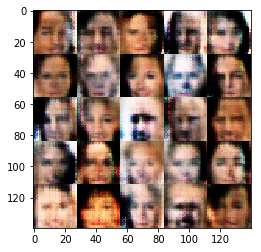

Epoch:0/1 Images:13440/202599 Discriminator Loss: 1.0906... Generator Loss: 1.4214
Epoch:0/1 Images:14080/202599 Discriminator Loss: 0.9675... Generator Loss: 1.4853
Epoch:0/1 Images:14720/202599 Discriminator Loss: 1.0352... Generator Loss: 0.8788
Epoch:0/1 Images:15360/202599 Discriminator Loss: 1.0295... Generator Loss: 1.0940
Epoch:0/1 Images:16000/202599 Discriminator Loss: 1.3942... Generator Loss: 0.4873
Epoch:0/1 Images:16640/202599 Discriminator Loss: 1.6516... Generator Loss: 3.4889
Epoch:0/1 Images:17280/202599 Discriminator Loss: 1.6433... Generator Loss: 0.6744
Epoch:0/1 Images:17920/202599 Discriminator Loss: 1.5961... Generator Loss: 0.6800
Epoch:0/1 Images:18560/202599 Discriminator Loss: 0.8720... Generator Loss: 1.4757
Epoch:0/1 Images:19200/202599 Discriminator Loss: 0.7108... Generator Loss: 2.0351


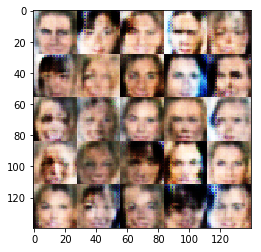

Epoch:0/1 Images:19840/202599 Discriminator Loss: 1.2367... Generator Loss: 0.9449
Epoch:0/1 Images:20480/202599 Discriminator Loss: 1.0447... Generator Loss: 0.9694
Epoch:0/1 Images:21120/202599 Discriminator Loss: 1.0569... Generator Loss: 0.9457
Epoch:0/1 Images:21760/202599 Discriminator Loss: 0.7858... Generator Loss: 1.8089
Epoch:0/1 Images:22400/202599 Discriminator Loss: 1.0985... Generator Loss: 0.8462
Epoch:0/1 Images:23040/202599 Discriminator Loss: 1.4543... Generator Loss: 0.4982
Epoch:0/1 Images:23680/202599 Discriminator Loss: 1.1780... Generator Loss: 0.7433
Epoch:0/1 Images:24320/202599 Discriminator Loss: 0.9781... Generator Loss: 1.0255
Epoch:0/1 Images:24960/202599 Discriminator Loss: 1.5681... Generator Loss: 0.5391
Epoch:0/1 Images:25600/202599 Discriminator Loss: 1.9006... Generator Loss: 0.9986


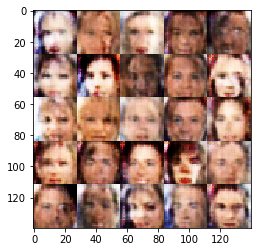

Epoch:0/1 Images:26240/202599 Discriminator Loss: 1.7284... Generator Loss: 0.3432
Epoch:0/1 Images:26880/202599 Discriminator Loss: 1.2928... Generator Loss: 1.0401
Epoch:0/1 Images:27520/202599 Discriminator Loss: 1.1479... Generator Loss: 1.1259
Epoch:0/1 Images:28160/202599 Discriminator Loss: 1.5918... Generator Loss: 0.3718
Epoch:0/1 Images:28800/202599 Discriminator Loss: 1.4633... Generator Loss: 0.5080
Epoch:0/1 Images:29440/202599 Discriminator Loss: 1.2206... Generator Loss: 0.9843
Epoch:0/1 Images:30080/202599 Discriminator Loss: 1.2450... Generator Loss: 0.8127
Epoch:0/1 Images:30720/202599 Discriminator Loss: 0.9498... Generator Loss: 1.1899
Epoch:0/1 Images:31360/202599 Discriminator Loss: 0.8938... Generator Loss: 2.0866
Epoch:0/1 Images:32000/202599 Discriminator Loss: 1.1661... Generator Loss: 1.0295


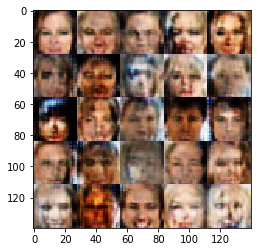

Epoch:0/1 Images:32640/202599 Discriminator Loss: 1.2705... Generator Loss: 0.6389
Epoch:0/1 Images:33280/202599 Discriminator Loss: 1.0626... Generator Loss: 1.1457
Epoch:0/1 Images:33920/202599 Discriminator Loss: 1.1856... Generator Loss: 1.0003
Epoch:0/1 Images:34560/202599 Discriminator Loss: 1.4162... Generator Loss: 0.5041
Epoch:0/1 Images:35200/202599 Discriminator Loss: 1.4412... Generator Loss: 0.5028
Epoch:0/1 Images:35840/202599 Discriminator Loss: 1.3755... Generator Loss: 0.8479
Epoch:0/1 Images:36480/202599 Discriminator Loss: 0.7926... Generator Loss: 1.4050
Epoch:0/1 Images:37120/202599 Discriminator Loss: 1.3926... Generator Loss: 0.6733
Epoch:0/1 Images:37760/202599 Discriminator Loss: 1.1506... Generator Loss: 0.9550
Epoch:0/1 Images:38400/202599 Discriminator Loss: 1.2137... Generator Loss: 0.7186


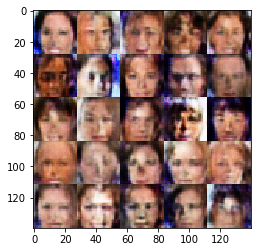

Epoch:0/1 Images:39040/202599 Discriminator Loss: 1.4306... Generator Loss: 0.6955
Epoch:0/1 Images:39680/202599 Discriminator Loss: 1.4131... Generator Loss: 1.2478
Epoch:0/1 Images:40320/202599 Discriminator Loss: 1.4985... Generator Loss: 0.7002
Epoch:0/1 Images:40960/202599 Discriminator Loss: 1.3895... Generator Loss: 0.9950
Epoch:0/1 Images:41600/202599 Discriminator Loss: 1.0882... Generator Loss: 0.9607
Epoch:0/1 Images:42240/202599 Discriminator Loss: 1.2024... Generator Loss: 0.7842
Epoch:0/1 Images:42880/202599 Discriminator Loss: 1.2815... Generator Loss: 0.7940
Epoch:0/1 Images:43520/202599 Discriminator Loss: 1.2642... Generator Loss: 0.8849
Epoch:0/1 Images:44160/202599 Discriminator Loss: 1.4315... Generator Loss: 0.6096
Epoch:0/1 Images:44800/202599 Discriminator Loss: 1.2978... Generator Loss: 1.0205


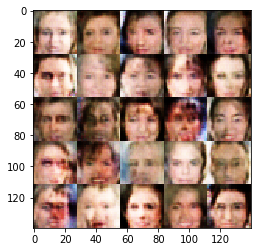

Epoch:0/1 Images:45440/202599 Discriminator Loss: 1.4673... Generator Loss: 0.5751
Epoch:0/1 Images:46080/202599 Discriminator Loss: 1.1895... Generator Loss: 0.8155
Epoch:0/1 Images:46720/202599 Discriminator Loss: 1.4209... Generator Loss: 0.8004
Epoch:0/1 Images:47360/202599 Discriminator Loss: 1.2305... Generator Loss: 1.0333
Epoch:0/1 Images:48000/202599 Discriminator Loss: 1.1314... Generator Loss: 1.0369
Epoch:0/1 Images:48640/202599 Discriminator Loss: 1.4025... Generator Loss: 0.5588
Epoch:0/1 Images:49280/202599 Discriminator Loss: 1.3050... Generator Loss: 0.7897
Epoch:0/1 Images:49920/202599 Discriminator Loss: 1.4876... Generator Loss: 0.8128
Epoch:0/1 Images:50560/202599 Discriminator Loss: 1.4271... Generator Loss: 0.7623
Epoch:0/1 Images:51200/202599 Discriminator Loss: 1.3541... Generator Loss: 0.6061


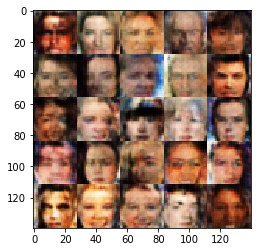

Epoch:0/1 Images:51840/202599 Discriminator Loss: 1.6917... Generator Loss: 0.3691
Epoch:0/1 Images:52480/202599 Discriminator Loss: 1.4774... Generator Loss: 0.5135
Epoch:0/1 Images:53120/202599 Discriminator Loss: 1.3694... Generator Loss: 0.6680
Epoch:0/1 Images:53760/202599 Discriminator Loss: 1.3679... Generator Loss: 0.6532
Epoch:0/1 Images:54400/202599 Discriminator Loss: 1.3269... Generator Loss: 0.8269
Epoch:0/1 Images:55040/202599 Discriminator Loss: 1.1636... Generator Loss: 0.7278
Epoch:0/1 Images:55680/202599 Discriminator Loss: 1.4169... Generator Loss: 0.7247
Epoch:0/1 Images:56320/202599 Discriminator Loss: 1.2557... Generator Loss: 0.9260
Epoch:0/1 Images:56960/202599 Discriminator Loss: 1.3798... Generator Loss: 0.5710
Epoch:0/1 Images:57600/202599 Discriminator Loss: 1.2508... Generator Loss: 1.0114


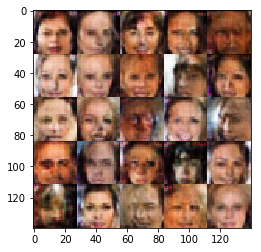

Epoch:0/1 Images:58240/202599 Discriminator Loss: 1.1996... Generator Loss: 0.9664
Epoch:0/1 Images:58880/202599 Discriminator Loss: 1.3632... Generator Loss: 0.6318
Epoch:0/1 Images:59520/202599 Discriminator Loss: 1.3206... Generator Loss: 1.1657
Epoch:0/1 Images:60160/202599 Discriminator Loss: 1.1821... Generator Loss: 0.9428
Epoch:0/1 Images:60800/202599 Discriminator Loss: 1.3677... Generator Loss: 0.6941
Epoch:0/1 Images:61440/202599 Discriminator Loss: 1.3547... Generator Loss: 0.6195
Epoch:0/1 Images:62080/202599 Discriminator Loss: 1.4252... Generator Loss: 0.6100
Epoch:0/1 Images:62720/202599 Discriminator Loss: 1.2759... Generator Loss: 0.8222
Epoch:0/1 Images:63360/202599 Discriminator Loss: 1.4290... Generator Loss: 0.8357
Epoch:0/1 Images:64000/202599 Discriminator Loss: 0.7966... Generator Loss: 2.0684


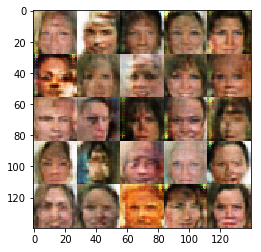

Epoch:0/1 Images:64640/202599 Discriminator Loss: 1.2906... Generator Loss: 0.6524
Epoch:0/1 Images:65280/202599 Discriminator Loss: 1.3005... Generator Loss: 0.7646
Epoch:0/1 Images:65920/202599 Discriminator Loss: 1.4356... Generator Loss: 0.6851
Epoch:0/1 Images:66560/202599 Discriminator Loss: 1.2704... Generator Loss: 0.9254
Epoch:0/1 Images:67200/202599 Discriminator Loss: 1.3393... Generator Loss: 0.6648
Epoch:0/1 Images:67840/202599 Discriminator Loss: 1.4656... Generator Loss: 0.5420
Epoch:0/1 Images:68480/202599 Discriminator Loss: 1.4553... Generator Loss: 0.5142
Epoch:0/1 Images:69120/202599 Discriminator Loss: 1.2989... Generator Loss: 0.7865
Epoch:0/1 Images:69760/202599 Discriminator Loss: 1.0718... Generator Loss: 1.2535
Epoch:0/1 Images:70400/202599 Discriminator Loss: 1.4258... Generator Loss: 0.6343


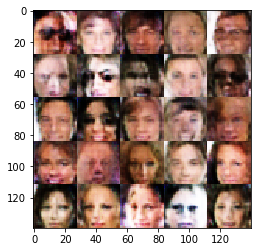

Epoch:0/1 Images:71040/202599 Discriminator Loss: 1.3257... Generator Loss: 0.7143
Epoch:0/1 Images:71680/202599 Discriminator Loss: 1.4007... Generator Loss: 0.5936
Epoch:0/1 Images:72320/202599 Discriminator Loss: 1.4051... Generator Loss: 0.6132
Epoch:0/1 Images:72960/202599 Discriminator Loss: 1.4038... Generator Loss: 0.5518
Epoch:0/1 Images:73600/202599 Discriminator Loss: 1.2932... Generator Loss: 0.8592
Epoch:0/1 Images:74240/202599 Discriminator Loss: 1.3570... Generator Loss: 0.6574
Epoch:0/1 Images:74880/202599 Discriminator Loss: 1.2234... Generator Loss: 0.8319
Epoch:0/1 Images:75520/202599 Discriminator Loss: 1.2687... Generator Loss: 0.7625
Epoch:0/1 Images:76160/202599 Discriminator Loss: 1.5994... Generator Loss: 0.5307
Epoch:0/1 Images:76800/202599 Discriminator Loss: 1.2732... Generator Loss: 0.9138


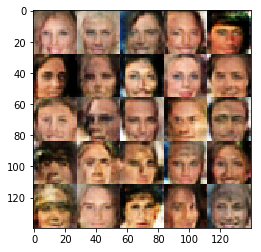

Epoch:0/1 Images:77440/202599 Discriminator Loss: 1.2213... Generator Loss: 1.0939
Epoch:0/1 Images:78080/202599 Discriminator Loss: 1.4716... Generator Loss: 0.4763
Epoch:0/1 Images:78720/202599 Discriminator Loss: 1.3213... Generator Loss: 0.6642
Epoch:0/1 Images:79360/202599 Discriminator Loss: 1.3115... Generator Loss: 0.6536
Epoch:0/1 Images:80000/202599 Discriminator Loss: 1.2914... Generator Loss: 0.8066
Epoch:0/1 Images:80640/202599 Discriminator Loss: 1.2355... Generator Loss: 0.8949
Epoch:0/1 Images:81280/202599 Discriminator Loss: 1.2782... Generator Loss: 0.7885
Epoch:0/1 Images:81920/202599 Discriminator Loss: 1.2487... Generator Loss: 0.7792
Epoch:0/1 Images:82560/202599 Discriminator Loss: 1.2760... Generator Loss: 0.7180
Epoch:0/1 Images:83200/202599 Discriminator Loss: 1.2987... Generator Loss: 0.8354


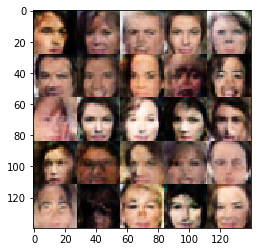

Epoch:0/1 Images:83840/202599 Discriminator Loss: 1.3686... Generator Loss: 0.6509
Epoch:0/1 Images:84480/202599 Discriminator Loss: 1.2800... Generator Loss: 0.8435
Epoch:0/1 Images:85120/202599 Discriminator Loss: 1.3026... Generator Loss: 0.6785
Epoch:0/1 Images:85760/202599 Discriminator Loss: 1.5366... Generator Loss: 0.4789
Epoch:0/1 Images:86400/202599 Discriminator Loss: 1.3389... Generator Loss: 0.9103
Epoch:0/1 Images:87040/202599 Discriminator Loss: 1.1375... Generator Loss: 0.9772
Epoch:0/1 Images:87680/202599 Discriminator Loss: 1.3646... Generator Loss: 0.8104
Epoch:0/1 Images:88320/202599 Discriminator Loss: 1.3405... Generator Loss: 0.7133
Epoch:0/1 Images:88960/202599 Discriminator Loss: 1.3112... Generator Loss: 0.6530
Epoch:0/1 Images:89600/202599 Discriminator Loss: 1.3931... Generator Loss: 0.7528


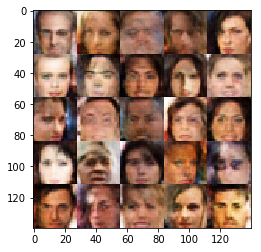

Epoch:0/1 Images:90240/202599 Discriminator Loss: 1.2516... Generator Loss: 0.8921
Epoch:0/1 Images:90880/202599 Discriminator Loss: 1.3979... Generator Loss: 0.5678
Epoch:0/1 Images:91520/202599 Discriminator Loss: 1.2007... Generator Loss: 1.0424
Epoch:0/1 Images:92160/202599 Discriminator Loss: 1.2049... Generator Loss: 1.0283
Epoch:0/1 Images:92800/202599 Discriminator Loss: 1.4371... Generator Loss: 0.7179
Epoch:0/1 Images:93440/202599 Discriminator Loss: 1.5772... Generator Loss: 0.5245
Epoch:0/1 Images:94080/202599 Discriminator Loss: 1.2816... Generator Loss: 0.8016
Epoch:0/1 Images:94720/202599 Discriminator Loss: 1.2482... Generator Loss: 0.7997
Epoch:0/1 Images:95360/202599 Discriminator Loss: 1.2953... Generator Loss: 0.7211
Epoch:0/1 Images:96000/202599 Discriminator Loss: 1.2223... Generator Loss: 0.9746


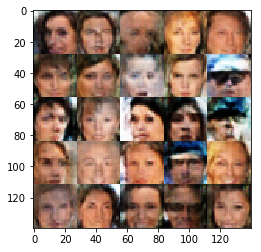

Epoch:0/1 Images:96640/202599 Discriminator Loss: 1.7426... Generator Loss: 0.3290
Epoch:0/1 Images:97280/202599 Discriminator Loss: 1.2136... Generator Loss: 0.7597
Epoch:0/1 Images:97920/202599 Discriminator Loss: 1.3899... Generator Loss: 0.5326
Epoch:0/1 Images:98560/202599 Discriminator Loss: 1.2842... Generator Loss: 0.7027
Epoch:0/1 Images:99200/202599 Discriminator Loss: 1.3305... Generator Loss: 0.6989
Epoch:0/1 Images:99840/202599 Discriminator Loss: 1.2908... Generator Loss: 0.6894
Epoch:0/1 Images:100480/202599 Discriminator Loss: 1.4607... Generator Loss: 0.5756
Epoch:0/1 Images:101120/202599 Discriminator Loss: 1.3700... Generator Loss: 0.8270
Epoch:0/1 Images:101760/202599 Discriminator Loss: 1.6097... Generator Loss: 0.4670
Epoch:0/1 Images:102400/202599 Discriminator Loss: 1.6230... Generator Loss: 0.4388


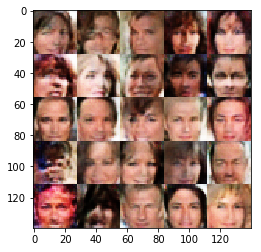

Epoch:0/1 Images:103040/202599 Discriminator Loss: 1.4307... Generator Loss: 0.8362
Epoch:0/1 Images:103680/202599 Discriminator Loss: 1.1499... Generator Loss: 0.9433
Epoch:0/1 Images:104320/202599 Discriminator Loss: 1.4491... Generator Loss: 0.6545
Epoch:0/1 Images:104960/202599 Discriminator Loss: 1.5939... Generator Loss: 0.5077
Epoch:0/1 Images:105600/202599 Discriminator Loss: 1.1975... Generator Loss: 0.8976
Epoch:0/1 Images:106240/202599 Discriminator Loss: 1.3484... Generator Loss: 0.8022
Epoch:0/1 Images:106880/202599 Discriminator Loss: 1.2965... Generator Loss: 0.8320
Epoch:0/1 Images:107520/202599 Discriminator Loss: 1.4358... Generator Loss: 0.8391
Epoch:0/1 Images:108160/202599 Discriminator Loss: 1.1613... Generator Loss: 1.0273
Epoch:0/1 Images:108800/202599 Discriminator Loss: 1.3180... Generator Loss: 0.7730


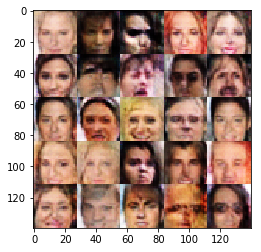

Epoch:0/1 Images:109440/202599 Discriminator Loss: 1.2578... Generator Loss: 0.8065
Epoch:0/1 Images:110080/202599 Discriminator Loss: 1.3938... Generator Loss: 0.5810
Epoch:0/1 Images:110720/202599 Discriminator Loss: 1.4281... Generator Loss: 0.5864
Epoch:0/1 Images:111360/202599 Discriminator Loss: 1.5622... Generator Loss: 0.5075
Epoch:0/1 Images:112000/202599 Discriminator Loss: 1.3752... Generator Loss: 0.8470
Epoch:0/1 Images:112640/202599 Discriminator Loss: 1.4674... Generator Loss: 0.5560
Epoch:0/1 Images:113280/202599 Discriminator Loss: 1.5170... Generator Loss: 0.4976
Epoch:0/1 Images:113920/202599 Discriminator Loss: 1.4570... Generator Loss: 0.6249
Epoch:0/1 Images:114560/202599 Discriminator Loss: 1.2202... Generator Loss: 0.8216
Epoch:0/1 Images:115200/202599 Discriminator Loss: 1.3669... Generator Loss: 0.6950


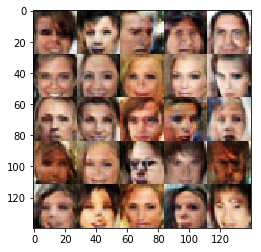

Epoch:0/1 Images:115840/202599 Discriminator Loss: 1.4748... Generator Loss: 0.6379
Epoch:0/1 Images:116480/202599 Discriminator Loss: 1.3365... Generator Loss: 0.7028
Epoch:0/1 Images:117120/202599 Discriminator Loss: 1.3164... Generator Loss: 0.7237
Epoch:0/1 Images:117760/202599 Discriminator Loss: 1.2066... Generator Loss: 0.7776
Epoch:0/1 Images:118400/202599 Discriminator Loss: 1.4275... Generator Loss: 0.7221
Epoch:0/1 Images:119040/202599 Discriminator Loss: 1.2414... Generator Loss: 1.2323
Epoch:0/1 Images:119680/202599 Discriminator Loss: 1.6872... Generator Loss: 0.4499
Epoch:0/1 Images:120320/202599 Discriminator Loss: 1.2747... Generator Loss: 0.7503
Epoch:0/1 Images:120960/202599 Discriminator Loss: 1.4619... Generator Loss: 0.5608
Epoch:0/1 Images:121600/202599 Discriminator Loss: 1.3234... Generator Loss: 0.7302


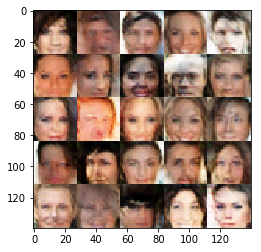

Epoch:0/1 Images:122240/202599 Discriminator Loss: 1.3190... Generator Loss: 0.7271
Epoch:0/1 Images:122880/202599 Discriminator Loss: 1.4406... Generator Loss: 0.5812
Epoch:0/1 Images:123520/202599 Discriminator Loss: 1.2952... Generator Loss: 0.8770
Epoch:0/1 Images:124160/202599 Discriminator Loss: 1.2392... Generator Loss: 0.8124
Epoch:0/1 Images:124800/202599 Discriminator Loss: 1.3759... Generator Loss: 0.8541
Epoch:0/1 Images:125440/202599 Discriminator Loss: 1.3132... Generator Loss: 0.6565
Epoch:0/1 Images:126080/202599 Discriminator Loss: 1.4521... Generator Loss: 0.6215
Epoch:0/1 Images:126720/202599 Discriminator Loss: 1.3225... Generator Loss: 0.7648
Epoch:0/1 Images:127360/202599 Discriminator Loss: 1.0905... Generator Loss: 0.9700
Epoch:0/1 Images:128000/202599 Discriminator Loss: 1.2796... Generator Loss: 0.7203


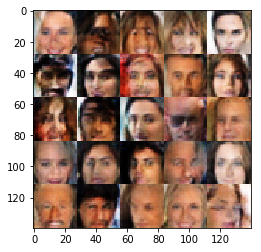

Epoch:0/1 Images:128640/202599 Discriminator Loss: 1.3554... Generator Loss: 0.6888
Epoch:0/1 Images:129280/202599 Discriminator Loss: 1.4241... Generator Loss: 0.7304
Epoch:0/1 Images:129920/202599 Discriminator Loss: 1.3954... Generator Loss: 0.6900
Epoch:0/1 Images:130560/202599 Discriminator Loss: 1.3847... Generator Loss: 0.9156
Epoch:0/1 Images:131200/202599 Discriminator Loss: 1.2766... Generator Loss: 0.7093
Epoch:0/1 Images:131840/202599 Discriminator Loss: 1.2942... Generator Loss: 0.7523
Epoch:0/1 Images:132480/202599 Discriminator Loss: 1.3191... Generator Loss: 0.6812
Epoch:0/1 Images:133120/202599 Discriminator Loss: 1.4357... Generator Loss: 0.5647
Epoch:0/1 Images:133760/202599 Discriminator Loss: 1.4500... Generator Loss: 0.5675
Epoch:0/1 Images:134400/202599 Discriminator Loss: 1.9065... Generator Loss: 0.4315


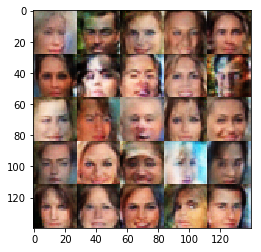

Epoch:0/1 Images:135040/202599 Discriminator Loss: 1.4207... Generator Loss: 0.6708
Epoch:0/1 Images:135680/202599 Discriminator Loss: 1.3107... Generator Loss: 0.9481
Epoch:0/1 Images:136320/202599 Discriminator Loss: 1.2459... Generator Loss: 0.7258
Epoch:0/1 Images:136960/202599 Discriminator Loss: 1.3290... Generator Loss: 1.0249
Epoch:0/1 Images:137600/202599 Discriminator Loss: 1.3060... Generator Loss: 0.6504
Epoch:0/1 Images:138240/202599 Discriminator Loss: 1.4030... Generator Loss: 0.6470
Epoch:0/1 Images:138880/202599 Discriminator Loss: 1.3903... Generator Loss: 0.6227
Epoch:0/1 Images:139520/202599 Discriminator Loss: 1.6105... Generator Loss: 0.5133
Epoch:0/1 Images:140160/202599 Discriminator Loss: 1.2975... Generator Loss: 0.9278
Epoch:0/1 Images:140800/202599 Discriminator Loss: 1.3530... Generator Loss: 0.6743


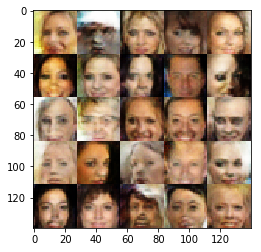

Epoch:0/1 Images:141440/202599 Discriminator Loss: 1.3308... Generator Loss: 0.6810
Epoch:0/1 Images:142080/202599 Discriminator Loss: 1.4161... Generator Loss: 0.5971
Epoch:0/1 Images:142720/202599 Discriminator Loss: 1.3974... Generator Loss: 0.7876
Epoch:0/1 Images:143360/202599 Discriminator Loss: 1.4130... Generator Loss: 0.6773
Epoch:0/1 Images:144000/202599 Discriminator Loss: 1.3939... Generator Loss: 0.8465
Epoch:0/1 Images:144640/202599 Discriminator Loss: 1.3278... Generator Loss: 0.6716
Epoch:0/1 Images:145280/202599 Discriminator Loss: 1.3699... Generator Loss: 0.6440
Epoch:0/1 Images:145920/202599 Discriminator Loss: 1.3435... Generator Loss: 0.6592
Epoch:0/1 Images:146560/202599 Discriminator Loss: 1.3510... Generator Loss: 0.6359
Epoch:0/1 Images:147200/202599 Discriminator Loss: 1.3284... Generator Loss: 0.6273


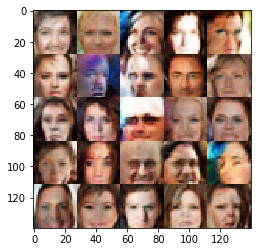

Epoch:0/1 Images:147840/202599 Discriminator Loss: 1.2990... Generator Loss: 0.7295
Epoch:0/1 Images:148480/202599 Discriminator Loss: 1.4328... Generator Loss: 0.6130
Epoch:0/1 Images:149120/202599 Discriminator Loss: 1.5953... Generator Loss: 0.5531
Epoch:0/1 Images:149760/202599 Discriminator Loss: 1.4030... Generator Loss: 0.7432
Epoch:0/1 Images:150400/202599 Discriminator Loss: 1.4394... Generator Loss: 0.5720
Epoch:0/1 Images:151040/202599 Discriminator Loss: 1.3903... Generator Loss: 0.6572
Epoch:0/1 Images:151680/202599 Discriminator Loss: 1.4208... Generator Loss: 0.6403
Epoch:0/1 Images:152320/202599 Discriminator Loss: 1.3616... Generator Loss: 0.7495
Epoch:0/1 Images:152960/202599 Discriminator Loss: 1.2949... Generator Loss: 0.8709
Epoch:0/1 Images:153600/202599 Discriminator Loss: 1.4030... Generator Loss: 0.7203


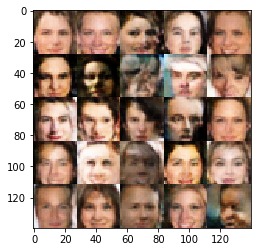

Epoch:0/1 Images:154240/202599 Discriminator Loss: 1.2210... Generator Loss: 0.8578
Epoch:0/1 Images:154880/202599 Discriminator Loss: 1.4867... Generator Loss: 0.6612
Epoch:0/1 Images:155520/202599 Discriminator Loss: 1.5251... Generator Loss: 0.6972
Epoch:0/1 Images:156160/202599 Discriminator Loss: 1.3109... Generator Loss: 0.7420
Epoch:0/1 Images:156800/202599 Discriminator Loss: 1.3251... Generator Loss: 0.7260
Epoch:0/1 Images:157440/202599 Discriminator Loss: 1.4067... Generator Loss: 0.6175
Epoch:0/1 Images:158080/202599 Discriminator Loss: 1.3619... Generator Loss: 0.6449
Epoch:0/1 Images:158720/202599 Discriminator Loss: 1.3841... Generator Loss: 0.6976
Epoch:0/1 Images:159360/202599 Discriminator Loss: 1.3728... Generator Loss: 0.7097
Epoch:0/1 Images:160000/202599 Discriminator Loss: 1.4846... Generator Loss: 0.8397


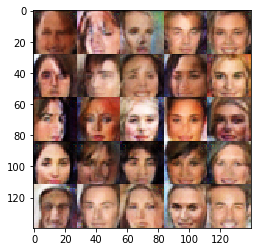

Epoch:0/1 Images:160640/202599 Discriminator Loss: 1.4218... Generator Loss: 0.6730
Epoch:0/1 Images:161280/202599 Discriminator Loss: 1.2478... Generator Loss: 0.7297
Epoch:0/1 Images:161920/202599 Discriminator Loss: 1.3314... Generator Loss: 0.6578
Epoch:0/1 Images:162560/202599 Discriminator Loss: 1.3171... Generator Loss: 0.7277
Epoch:0/1 Images:163200/202599 Discriminator Loss: 1.3524... Generator Loss: 0.7738
Epoch:0/1 Images:163840/202599 Discriminator Loss: 1.4059... Generator Loss: 0.7502
Epoch:0/1 Images:164480/202599 Discriminator Loss: 1.4615... Generator Loss: 0.6609
Epoch:0/1 Images:165120/202599 Discriminator Loss: 1.3363... Generator Loss: 0.7930
Epoch:0/1 Images:165760/202599 Discriminator Loss: 1.3543... Generator Loss: 0.6849
Epoch:0/1 Images:166400/202599 Discriminator Loss: 1.4348... Generator Loss: 0.6568


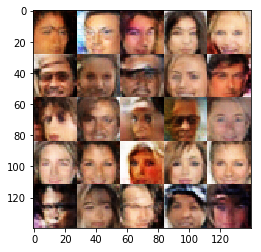

Epoch:0/1 Images:167040/202599 Discriminator Loss: 1.5285... Generator Loss: 0.7890
Epoch:0/1 Images:167680/202599 Discriminator Loss: 1.3070... Generator Loss: 0.8681
Epoch:0/1 Images:168320/202599 Discriminator Loss: 1.2971... Generator Loss: 0.7393
Epoch:0/1 Images:168960/202599 Discriminator Loss: 1.5117... Generator Loss: 0.5083
Epoch:0/1 Images:169600/202599 Discriminator Loss: 1.2282... Generator Loss: 0.8913
Epoch:0/1 Images:170240/202599 Discriminator Loss: 1.3371... Generator Loss: 0.7647
Epoch:0/1 Images:170880/202599 Discriminator Loss: 1.3255... Generator Loss: 0.6671
Epoch:0/1 Images:171520/202599 Discriminator Loss: 1.3520... Generator Loss: 0.6750
Epoch:0/1 Images:172160/202599 Discriminator Loss: 1.2647... Generator Loss: 0.8186
Epoch:0/1 Images:172800/202599 Discriminator Loss: 1.2006... Generator Loss: 0.7761


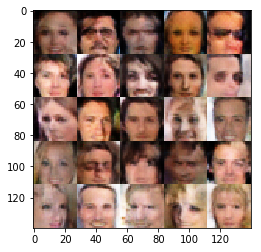

Epoch:0/1 Images:173440/202599 Discriminator Loss: 1.2689... Generator Loss: 0.7605
Epoch:0/1 Images:174080/202599 Discriminator Loss: 1.3745... Generator Loss: 0.6700
Epoch:0/1 Images:174720/202599 Discriminator Loss: 1.3541... Generator Loss: 0.6567
Epoch:0/1 Images:175360/202599 Discriminator Loss: 1.4420... Generator Loss: 0.5821
Epoch:0/1 Images:176000/202599 Discriminator Loss: 1.2888... Generator Loss: 0.7010
Epoch:0/1 Images:176640/202599 Discriminator Loss: 1.5840... Generator Loss: 0.6456
Epoch:0/1 Images:177280/202599 Discriminator Loss: 1.4437... Generator Loss: 0.8556
Epoch:0/1 Images:177920/202599 Discriminator Loss: 1.3281... Generator Loss: 0.6098
Epoch:0/1 Images:178560/202599 Discriminator Loss: 1.3707... Generator Loss: 0.7125
Epoch:0/1 Images:179200/202599 Discriminator Loss: 1.4117... Generator Loss: 0.6487


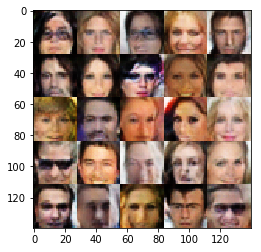

Epoch:0/1 Images:179840/202599 Discriminator Loss: 1.3073... Generator Loss: 0.6797
Epoch:0/1 Images:180480/202599 Discriminator Loss: 1.2694... Generator Loss: 0.7907
Epoch:0/1 Images:181120/202599 Discriminator Loss: 1.1902... Generator Loss: 0.9024
Epoch:0/1 Images:181760/202599 Discriminator Loss: 1.3386... Generator Loss: 0.7207
Epoch:0/1 Images:182400/202599 Discriminator Loss: 1.3670... Generator Loss: 0.6542
Epoch:0/1 Images:183040/202599 Discriminator Loss: 1.4337... Generator Loss: 0.7659
Epoch:0/1 Images:183680/202599 Discriminator Loss: 1.5103... Generator Loss: 0.5784
Epoch:0/1 Images:184320/202599 Discriminator Loss: 1.5017... Generator Loss: 0.5658
Epoch:0/1 Images:184960/202599 Discriminator Loss: 1.4429... Generator Loss: 0.6655
Epoch:0/1 Images:185600/202599 Discriminator Loss: 1.4299... Generator Loss: 0.6138


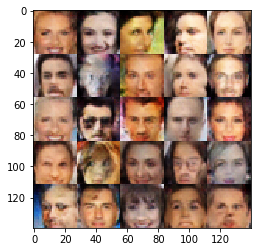

Epoch:0/1 Images:186240/202599 Discriminator Loss: 1.4478... Generator Loss: 0.6651
Epoch:0/1 Images:186880/202599 Discriminator Loss: 1.3543... Generator Loss: 0.6560
Epoch:0/1 Images:187520/202599 Discriminator Loss: 1.2336... Generator Loss: 0.9491
Epoch:0/1 Images:188160/202599 Discriminator Loss: 1.4753... Generator Loss: 0.6164
Epoch:0/1 Images:188800/202599 Discriminator Loss: 1.4073... Generator Loss: 0.6113
Epoch:0/1 Images:189440/202599 Discriminator Loss: 1.1167... Generator Loss: 0.9584
Epoch:0/1 Images:190080/202599 Discriminator Loss: 1.2946... Generator Loss: 0.7320
Epoch:0/1 Images:190720/202599 Discriminator Loss: 1.3858... Generator Loss: 0.7581
Epoch:0/1 Images:191360/202599 Discriminator Loss: 1.3484... Generator Loss: 0.6736
Epoch:0/1 Images:192000/202599 Discriminator Loss: 1.5687... Generator Loss: 0.6021


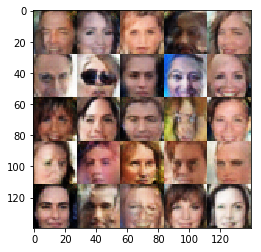

Epoch:0/1 Images:192640/202599 Discriminator Loss: 1.1311... Generator Loss: 1.0252
Epoch:0/1 Images:193280/202599 Discriminator Loss: 1.4442... Generator Loss: 0.5544
Epoch:0/1 Images:193920/202599 Discriminator Loss: 1.4225... Generator Loss: 0.6941
Epoch:0/1 Images:194560/202599 Discriminator Loss: 1.4918... Generator Loss: 0.6133
Epoch:0/1 Images:195200/202599 Discriminator Loss: 1.3574... Generator Loss: 0.7460
Epoch:0/1 Images:195840/202599 Discriminator Loss: 1.3216... Generator Loss: 0.6721
Epoch:0/1 Images:196480/202599 Discriminator Loss: 1.3240... Generator Loss: 0.7419
Epoch:0/1 Images:197120/202599 Discriminator Loss: 1.3677... Generator Loss: 0.6994
Epoch:0/1 Images:197760/202599 Discriminator Loss: 1.2691... Generator Loss: 0.7753
Epoch:0/1 Images:198400/202599 Discriminator Loss: 1.2907... Generator Loss: 0.6911


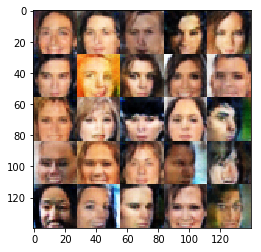

Epoch:0/1 Images:199040/202599 Discriminator Loss: 1.5060... Generator Loss: 0.6135
Epoch:0/1 Images:199680/202599 Discriminator Loss: 1.3578... Generator Loss: 0.7170
Epoch:0/1 Images:200320/202599 Discriminator Loss: 1.3465... Generator Loss: 0.6919
Epoch:0/1 Images:200960/202599 Discriminator Loss: 1.2275... Generator Loss: 0.8114
Epoch:0/1 Images:201600/202599 Discriminator Loss: 1.4879... Generator Loss: 0.6337
Epoch:0/1 Images:202240/202599 Discriminator Loss: 1.4954... Generator Loss: 0.6380


In [127]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.